[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb)

## Generative Adversarial Network (GAN)
GANs are a form of neural network in which two sub-networks (the encoder and decoder) are trained on opposing loss functions: an encoder that is trained to produce data which is indiscernable from the true data, and a decoder that is trained to discern between the data and generated data.

![gan](https://github.com/timsainb/tensorflow2-generative-models/blob/master/imgs/gan.png?raw=1)

### Install packages if in colab

In [1]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

### load packages

In [103]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd


In [3]:
print(tf.__version__)

2.3.0


### Create a fashion-MNIST dataset

In [30]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
tf.random.set_seed(123456789)

In [5]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

11493376/11490434 [==============================] - 0s 0us/step


### Define the network as tf.keras.model object

In [6]:
class GAN(tf.keras.Model):
    """ a basic GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


### Define the network architecture

In [92]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

### Create Model

In [93]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

### Train the model

In [94]:
# exampled data for plotting results
nums = tf.random.normal(shape=(BATCH_SIZE, N_Z))
def plot_reconstruction(model, nums, nex=8, zm=2, nr=3, nc=4, show=True):
    samples = model.generate(nums)
    aux = 0
    for axix in range(nr):
      for axiy in range(nc):
        axs[axix,axiy].matshow(
                    samples.numpy()[aux].squeeze(), cmap=plt.cm.Greys_r, vmin=0, vmax=1
                )
        axs[axix,axiy].axis('off')
        aux += 1
    if show:
      plt.show()
    return axs

In [95]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 99 | disc_loss: 0.7303189039230347 | gen_loss: 1.9860544204711914


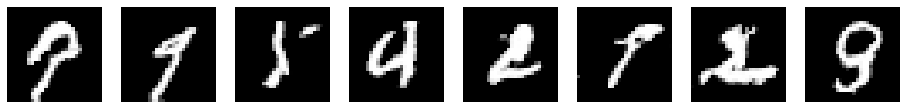

In [37]:
n_epochs = 100
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model, nums)

In [102]:
plt.plot(losses["disc_loss"], 'k', label="Disc")
plt.plot(losses["gen_loss"], 'r', label="Gen")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss-GAN.pdf", bbox_inches='tight')
plt.show()

RuntimeError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fabd2fdf9d8> (for post_execute):


RuntimeError: ignored

RuntimeError: ignored

<Figure size 432x288 with 1 Axes>

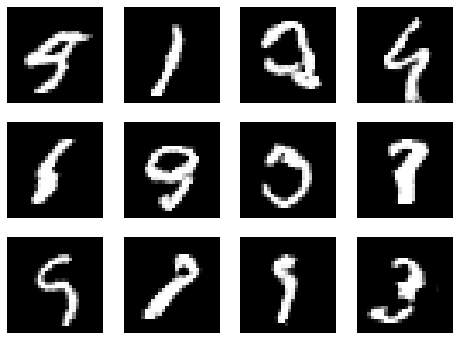

In [96]:
def anim(i):
  # train
  for batch, train_x in zip(range(N_TRAIN_BATCHES), train_dataset):
      model.train(train_x)
  # test on holdout
  loss = []
  for batch, test_x in zip(range(N_TEST_BATCHES), test_dataset):
      loss.append(model.compute_loss(test_x))
  losses.loc[len(losses)] = np.mean(loss, axis=0)
  # plot results
  axs = plot_reconstruction(model, nums, nex=12, show=False)
  return axs

zm = 2
nex = 12
nr = 3
nc = int(np.ceil(nex/nr))
fig, axs = plt.subplots(ncols=nc, nrows=nr, figsize=(zm * nc, zm * nr))
desired_time = 10
epochs = 150
ani = FuncAnimation(fig, anim, frames=epochs,
                    interval=int(1000*desired_time/epochs))
ani.save("test.mp4")